In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pickle as pkl
from multihist import Histdd

import flamedisx as fd

import os

/Users/Robert/anaconda3/envs/flamedisx/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/Robert/anaconda3/envs/flamedisx/lib/python3.11/site-packages/wimprates/__init__.py:6: UserWarning: Default WIMP parameters are changed in accordance with https://arxiv.org/abs/2105.00599 (github.com/JelleAalbers/wimprates/pull/14)
  warnings.warn(


In [2]:
pdfs = [dict(), dict()]

## ROI for templates

In [3]:
xlzd_source = fd.xlzd.XLZDERSource(configuration='60t')

cS1_min = xlzd_source.cS1_min
cS1_max = xlzd_source.cS1_max
log10_cS2_min = xlzd_source.log10_cS2_min
log10_cS2_max = xlzd_source.log10_cS2_max

/Users/Robert/anaconda3/envs/flamedisx/lib/python3.11/site-packages/flamedisx/source.py:271: UserWarning: Defaults for unused settings ignored: {'configuration': '60t'}
  warnings.warn(f"Defaults for unused settings ignored: {unused}")


## Background source

In [4]:
SolarER = fd.xlzd.XLZDvERSource(configuration='60t',
                                drift_field_V_cm=80., gas_field_kV_cm=7.5,
                                elife_ns=10000e3, g1=0.27)

/Users/Robert/anaconda3/envs/flamedisx/lib/python3.11/site-packages/flamedisx/source.py:271: UserWarning: Defaults for unused settings ignored: {'configuration': '60t'}
  warnings.warn(f"Defaults for unused settings ignored: {unused}")


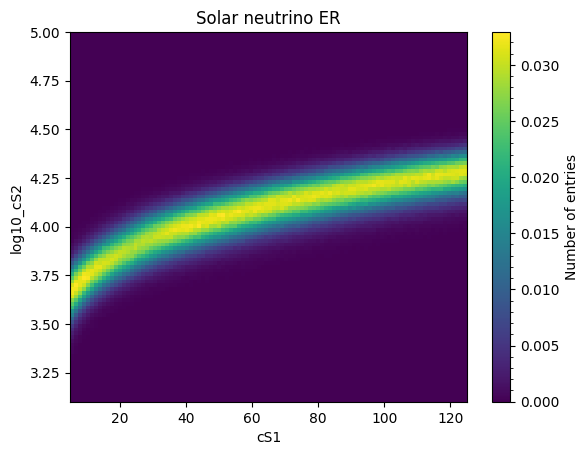

In [5]:
SolarER_hist = Histdd(bins=100, range=[[cS1_min, cS1_max], [log10_cS2_min, log10_cS2_max]], axis_names=['cS1', 'log10_cS2'])

SolarER_data = SolarER.simulate(int(1e7))

SolarER_hist.add(SolarER_data['cs1'], np.log10(SolarER_data['cs2']))

SolarER_mu = SolarER.estimate_mu(n_trials=int(1e7))
SolarER_hist.histogram = SolarER_hist.histogram / SolarER_hist.n * SolarER_mu

SolarER_hist.plot()
plt.title('Solar neutrino ER')

pdfs[0]['SolarER'] = SolarER_hist

In [6]:
print(SolarER_mu)

34.194744


## Signal source

In [7]:
CEvNS_other = fd.xlzd.XLZDvNROtherSource(configuration='60t',
                                         drift_field_V_cm=80., gas_field_kV_cm=7.5,
                                         elife_ns=10000e3, g1=0.27)

/Users/Robert/anaconda3/envs/flamedisx/lib/python3.11/site-packages/flamedisx/source.py:271: UserWarning: Defaults for unused settings ignored: {'configuration': '60t'}
  warnings.warn(f"Defaults for unused settings ignored: {unused}")


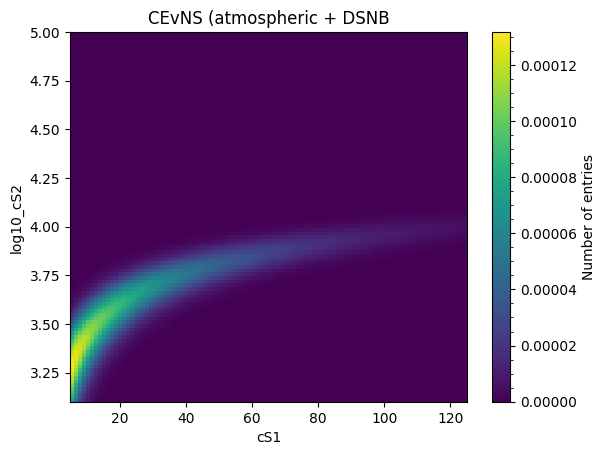

In [8]:
CEvNS_other_hist = Histdd(bins=100, range=[[cS1_min, cS1_max], [log10_cS2_min, log10_cS2_max]], axis_names=['cS1', 'log10_cS2'])

CEvNS_other_data = CEvNS_other.simulate(int(1e7))

CEvNS_other_hist.add(CEvNS_other_data['cs1'], np.log10(CEvNS_other_data['cs2']))

CEvNS_other_mu = CEvNS_other.estimate_mu(n_trials=int(1e7))
CEvNS_other_hist.histogram = CEvNS_other_hist.histogram / CEvNS_other_hist.n * CEvNS_other_mu

CEvNS_other_hist.plot()
plt.title('CEvNS (atmospheric + DSNB')

pdfs[1]['CEvNS_other'] = CEvNS_other_hist

In [9]:
print(CEvNS_other_mu)

0.043543365


## Save all PDFs

In [10]:
if not os.path.exists('PDFs'):
    os.makedirs('PDFs')

In [11]:
# pkl.dump(pdfs, open('PDFs/pdfs_CEvNS_disco_60t.pkl', 'wb'))

## ROC curve between CEvNS_other and SolarER

In [12]:
def hist_to_cdf(hist, ordering):
    return np.cumsum(hist.histogram.ravel()[ordering]) / hist.n

In [13]:
def ROC_2D(template_sig, template_bg):
    ratio = (template_bg + 1e-10) / (template_sig + 1e-10)
    ratio_ordering = np.argsort(ratio.histogram.ravel())

    roc = (hist_to_cdf(template_bg, ratio_ordering),
           hist_to_cdf(template_sig, ratio_ordering))

    return roc

Text(1.0539453906399926e-07, 0.6, 'Background fraction @ 50% signal: 8.33e-04')

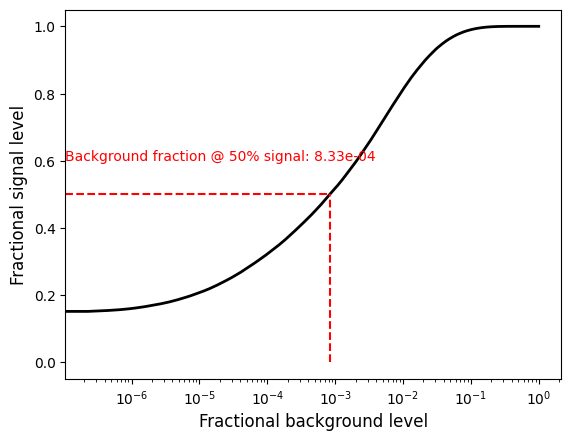

In [14]:
roc = ROC_2D(CEvNS_other_hist, SolarER_hist)
bg_at_50_sig = np.interp(0.5, xp=roc[1], fp=roc[0])

plt.plot(*roc, linewidth=2, color='k')
plt.xscale('log')
plt.xlabel('Fractional background level', fontsize=12)
plt.ylabel('Fractional signal level', fontsize=12)
plt.hlines(0.5, 0., bg_at_50_sig, color='r', linestyle='--')
plt.vlines(bg_at_50_sig, 0., 0.5, color='r', linestyle='--')
plt.text(plt.gca().get_xlim()[0], 0.6, f'Background fraction @ 50% signal: {bg_at_50_sig:.2e}', color='r')